<a href="https://colab.research.google.com/github/Navya-S/ERA/blob/main/ERA1S7F2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [20]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from model import Model2

In [21]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [22]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [23]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [31]:
# !pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Model2().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
              ReLU-3            [-1, 8, 26, 26]               0
            Conv2d-4            [-1, 8, 24, 24]             576
       BatchNorm2d-5            [-1, 8, 24, 24]              16
              ReLU-6            [-1, 8, 24, 24]               0
            Conv2d-7            [-1, 8, 22, 22]             576
       BatchNorm2d-8            [-1, 8, 22, 22]              16
              ReLU-9            [-1, 8, 22, 22]               0
        MaxPool2d-10            [-1, 8, 11, 11]               0
           Conv2d-11             [-1, 16, 9, 9]           1,152
      BatchNorm2d-12             [-1, 16, 9, 9]              32
             ReLU-13             [-1, 16, 9, 9]               0
           Conv2d-14             [

# Training and Testing

All right, so we have 6.3M params, and that's too many, we know that. But the purpose of this notebook is to set things right for our future experiments.

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [32]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [33]:
model =  Model2().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.15251775085926056 Batch_id=468 Accuracy=94.01: 100%|██████████| 469/469 [00:14<00:00, 32.48it/s] 



Test set: Average loss: 0.0564, Accuracy: 9818/10000 (98.18%)

EPOCH: 1


Loss=0.1223703920841217 Batch_id=468 Accuracy=98.29: 100%|██████████| 469/469 [00:13<00:00, 33.79it/s]   



Test set: Average loss: 0.0436, Accuracy: 9864/10000 (98.64%)

EPOCH: 2


Loss=0.05577691271901131 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:14<00:00, 31.55it/s]  



Test set: Average loss: 0.0407, Accuracy: 9872/10000 (98.72%)

EPOCH: 3


Loss=0.04054643586277962 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:13<00:00, 33.74it/s]  



Test set: Average loss: 0.0331, Accuracy: 9899/10000 (98.99%)

EPOCH: 4


Loss=0.05943077430129051 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:14<00:00, 31.82it/s]  



Test set: Average loss: 0.0329, Accuracy: 9892/10000 (98.92%)

EPOCH: 5


Loss=0.05118642374873161 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:14<00:00, 33.25it/s]  



Test set: Average loss: 0.0310, Accuracy: 9894/10000 (98.94%)

EPOCH: 6


Loss=0.1277197301387787 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:14<00:00, 31.68it/s]   



Test set: Average loss: 0.0343, Accuracy: 9895/10000 (98.95%)

EPOCH: 7


Loss=0.013287325389683247 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:14<00:00, 33.28it/s]  



Test set: Average loss: 0.0266, Accuracy: 9904/10000 (99.04%)

EPOCH: 8


Loss=0.013216898776590824 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:14<00:00, 31.48it/s] 



Test set: Average loss: 0.0341, Accuracy: 9896/10000 (98.96%)

EPOCH: 9


Loss=0.019939091056585312 Batch_id=468 Accuracy=99.41: 100%|██████████| 469/469 [00:14<00:00, 33.02it/s] 



Test set: Average loss: 0.0306, Accuracy: 9906/10000 (99.06%)

EPOCH: 10


Loss=0.01078379899263382 Batch_id=468 Accuracy=99.46: 100%|██████████| 469/469 [00:15<00:00, 31.19it/s]  



Test set: Average loss: 0.0255, Accuracy: 9916/10000 (99.16%)

EPOCH: 11


Loss=0.0417502336204052 Batch_id=468 Accuracy=99.53: 100%|██████████| 469/469 [00:14<00:00, 33.23it/s]   



Test set: Average loss: 0.0242, Accuracy: 9921/10000 (99.21%)

EPOCH: 12


Loss=0.0032222894951701164 Batch_id=468 Accuracy=99.61: 100%|██████████| 469/469 [00:14<00:00, 32.43it/s]



Test set: Average loss: 0.0288, Accuracy: 9900/10000 (99.00%)

EPOCH: 13


Loss=0.03235359117388725 Batch_id=468 Accuracy=99.60: 100%|██████████| 469/469 [00:13<00:00, 34.59it/s]   



Test set: Average loss: 0.0262, Accuracy: 9915/10000 (99.15%)

EPOCH: 14


Loss=0.0028480624314397573 Batch_id=468 Accuracy=99.62: 100%|██████████| 469/469 [00:14<00:00, 32.52it/s]



Test set: Average loss: 0.0287, Accuracy: 9903/10000 (99.03%)



In [35]:
t = [t_items.item() for t_items in train_losses]

Text(0.5, 1.0, 'Test Accuracy')

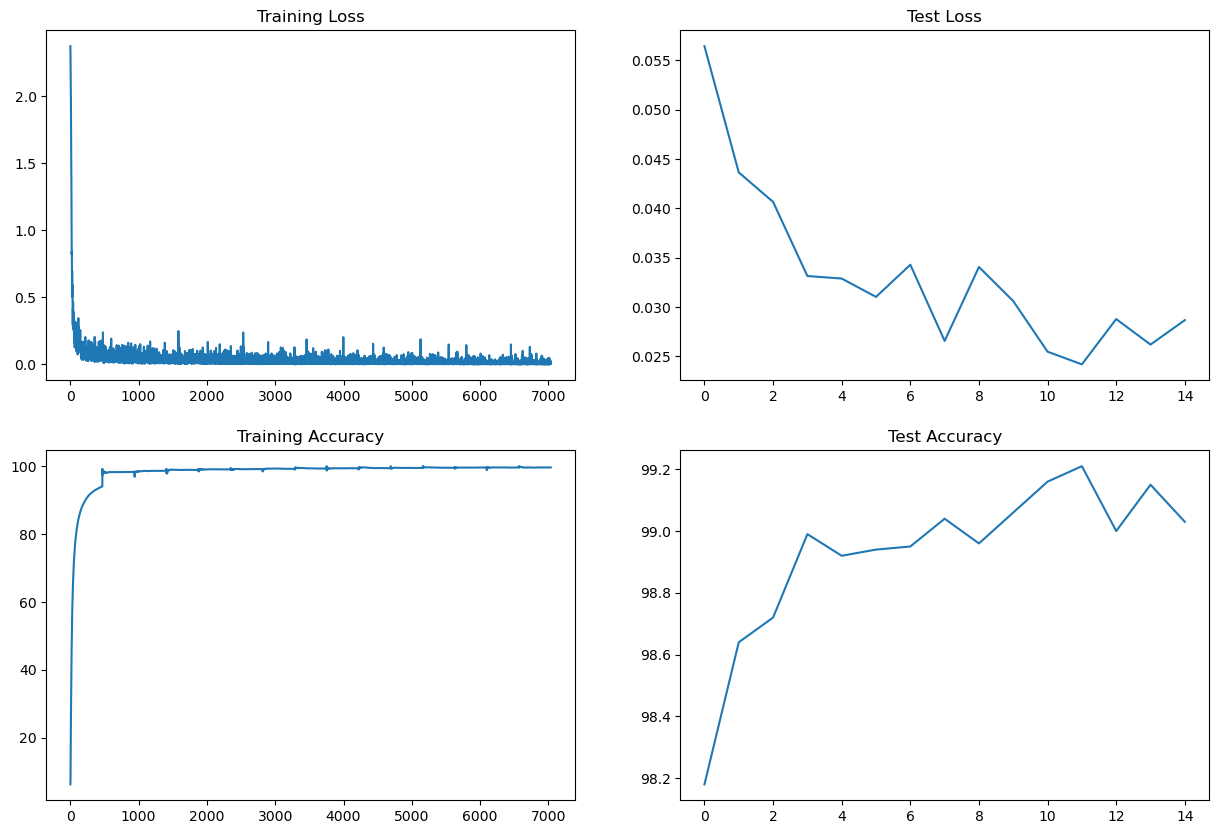

In [36]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")